In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Read in data
df = pd.read_csv(
    "../../data/brownfields_data_with_county_geoid/brownfields_data_with_county_geoid.csv"
)

/home/weimachine/.virtualenvs/data_template/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19,20,21,22,23,43,44,46,48,53,57,61,62,64,65,67,68,69,74,76,77,78,86,87,89,98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
assessment = "Phase II Environmental Assessment"

# Subset to data with complete assessment info
df = df[
        (df["Type of Brownfields Grant"] == "Assessment") &
        (df["Amt of Assessment Funding"] > 0) & 
        (df["Assessment Phase"] == assessment) &
        (df["Assessment Completion Date"] < "2021-03-01")
    ]

,Past Use,count,mean,std,min,25%,50%,75%,max
0,Commercial,2975.0,25703.497580,66846.975754,1.0,9236.00,17346.0,30851.0,3304535.0
1,Greenspace,263.0,23010.815589,30196.855085,140.0,7609.00,14248.0,26323.0,238215.0
2,Industrial,1710.0,42629.905877,74557.532248,1.0,12936.85,26581.0,48617.5,1694917.0
3,Residential,516.0,12608.728798,14944.168358,1.0,2075.00,7361.0,17900.0,107511.0


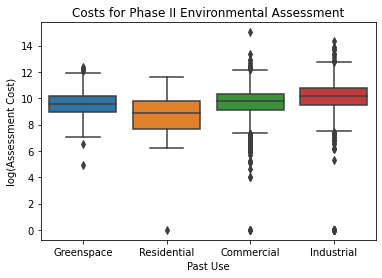

In [4]:
past_use_cols = [
    "Past Use: Greenspace (arces)",
    "Past Use: Residential (arces)",
    "Past Use: Commercial (arces)",
    "Past Use: Industrial (arces)",
]

assessment_cols = [
    "ACRES Property ID", 
    "Assessment Phase", 
    "Assessment Start Date", 
    "Assessment Completion Date",
    "Source of Assessment Funding", 
    "Entity Providing Assmnt Funds", 
    "Amt of Assessment Funding",
]

# Find the "pure usage" properties, i.e., the properties that ONLY
# had greenspace, or only had residential, or only had commericial,
# or only had industrial.

# Compare the assessment cost of greenspace-only properties to
# residential-only, commercial-only and industrial-only.

pure_dfs = []

for use in past_use_cols:
    # Build pure_df, a dataset of grants for "pure usage" properties
    pure_df = df[(df[use] > 0)]
    other_uses = [x for x in past_use_cols if x != use]
    for x in other_uses:
        pure_df = pure_df[(pure_df[x] == 0) | pd.isna(pure_df[x])]
    
    # Drop duplicate grant & assessment info
    pure_df = pure_df.drop_duplicates(subset=[use]+assessment_cols)
    
    # For a given property, add up assessment funding from all grants
    pure_df = pure_df.groupby(["ACRES Property ID"]) \
        .agg({use: "max", "Amt of Assessment Funding": "sum"}).reset_index()

    # Clean up columns
    pure_df["Past Use"] = use.split(" ")[2]
    pure_df["log(Assessment Cost)"] = pure_df["Amt of Assessment Funding"] \
        .apply(lambda x: np.log(x))
    pure_df["Assessment Cost"] = pure_df["Amt of Assessment Funding"]
    
    # Add pure_df to a growing list of pure_df's
    pure_dfs.append(
        pure_df[["Past Use", "log(Assessment Cost)", "Assessment Cost"]]
    )

# Combine the pure_df's into a single dataframe
plot_df = pd.concat(pure_dfs)

# Boxplot of assessment costs
sns.boxplot(x="Past Use", y="log(Assessment Cost)", data=plot_df) \
           .set_title(f"Costs for {assessment}")

# Table of assessment costs
plot_df.groupby("Past Use")["Assessment Cost"].describe().reset_index()